# Homework 3

Warning 1: some problems require (especially the lemmatization part) significant amount of time, so it is better to start early (!)

Warning 2: it is critical to describe and explain what you are doing and why, use markdown cells

In [ ]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
from sklearn import datasets
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso,  LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.svm import SVC
import math
import statsmodels.api as sm
import sys
%matplotlib inline

sns.set(style="darkgrid")

# PART 1: Logit model


We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the  l2  and  l1  penalties (Elastic Net).

Each object in the training dataset is indexed with  i  and described by pair: features  xi∈RK  and binary labels  yi . The model parametrized with bias  w0∈R  and weights  w∈RK .

The optimization problem with respect to the  w0,w  is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$

1. [0.5 points] Find the gradient of the Elastic Net loss and write its formulas (better in latex format)


$$∇λL=(\frac{1}{N} \sum_{i = 1}^{N}-\frac{x_iy_ie^{y_i(w^T x_i + w_0)}}{e^{y_i(w^T x_i + w0)} + 1} + \gamma sign(w) + 2 \beta w, -\frac{1}{N} \sum_{i = 1}^{N}\frac{y_ie^{y_i(w^T x_i + w_0)}}{e^{y_i(w^T x_i + w_0)} + 1})$$

2. [0.5 points] Implement the Elastic Net loss (as a function)

In [ ]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    return np.log(1 + np.exp(-y * (X @ w + w0))).mean() + gamma * np.linalg.norm(w, ord=1) + beta * (np.linalg.norm(w, ord=2) ** 2)


3. [0.5 points] Implement the gradient (as a function)

In [ ]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:

    grad_w = np.mean(-X * y.reshape(-1, 1) * np.exp(-y * (X @ w.T + w0)).reshape(-1, 1) / (1 + np.exp(-y * (X @ w.T + w0))).reshape(-1, 1) + gamma * np.sign(w) + 2 * beta * w, axis=0)
    grad_w0 = np.mean(-y * np.exp(-y * (X @ w.T + w0)) / (1 + np.exp(-y * (X @ w.T + w0))), axis=0)

    return grad_w, grad_w0 


Check yourself

In [ ]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0, gamma = 1.0, beta = 1.0)

print(grad_w, grad_w0)

assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)




[-2.73262181 -1.87176392  1.30051023  2.53598816 -2.71198278] -0.20782319347690742



4. [1 point] Implement gradient descent and plot the decision boundary of the result
The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from tqdm.notebook import tqdm

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42):  
        self.beta = beta        
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.learning_rate = lr
        self.random_state = random_state

        self.loss_history = []
        
    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        
        W_init = np.random.normal(0, 0.01, X.shape[1])
        W0_init = np.random.normal(0, 0.01)
        W_init_grad, W0_init_grad = get_grad(X, y, W_init, W0_init, self.gamma, self.beta)

        self.W = W_init.copy()
        self.W0 = W0_init
        W_grad = W_init_grad.copy()
        W0_grad = W0_init_grad

        for k in tqdm(range(self.max_iter + 1)):
            if np.linalg.norm(W_grad) ** 2 / np.linalg.norm(W_init_grad) ** 2 < self.tolerance:
                break

            self.W -= self.learning_rate * W_grad
            self.W0 -= self.learning_rate * W0_grad

            W_grad, W0_grad = get_grad(X, y, self.W, self.W0, self.gamma, self.beta)
            
            current_loss = loss(X, y, self.W, self.W0, self.gamma, self.beta)
            self.loss_history.append(current_loss)

        return self
    
    def predict(self, X):
        # return vector of predicted labels for each object from X
        # your code here

        return np.argmax(self.predict_proba(X).T, axis=1)
        
    def predict_proba(self, X):
        return np.array([1 / (1 + np.exp(np.dot(X, self.W) + self.W0)),\
                         1 / (1 + np.exp(-np.dot(X, self.W) - self.W0))])  

In [ ]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

X.shape, y.shape

((180, 2), (180,))

In [ ]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

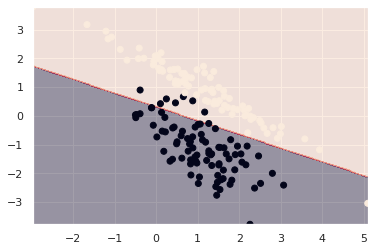

In [ ]:
model = Logit(beta=0, gamma=0, lr=1e-3, tolerance=0.01, max_iter=100000)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

5. [0.5 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

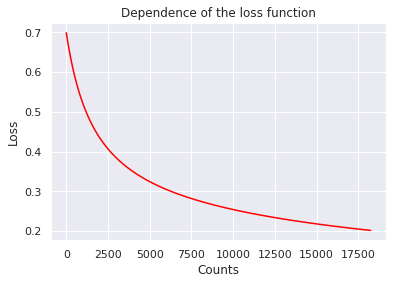

In [ ]:
plt.plot(model.loss_history, color = 'red')
plt.title('Dependence of the loss function')
plt.xlabel('Counts')
plt.ylabel('Loss')
plt.show()

# PART 2: Support Vector Machines
6. [1 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:

* Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some 
Kernels have hypermeters: don't forget to try different.
* Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score. Make plots for the dependencies between metrics and parameters. Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

0.9479840716774515 0.946808510638298


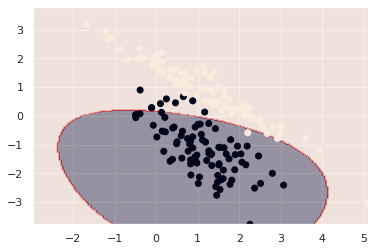

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score

clf = SVC(C = 0.00001, kernel='rbf')
clf.fit(X, y)
y_pred = clf.predict(X)

print(roc_auc_score(y_pred, y), f1_score(y_pred, y))
plot_decision_boundary(clf, X, y)

0.96875 0.967741935483871


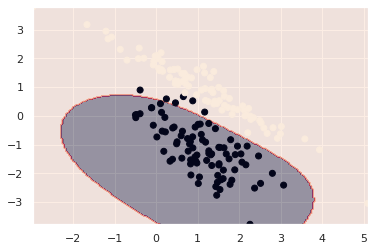

In [ ]:
clf = SVC(C = 0.1, kernel='rbf')
clf.fit(X, y)
y_pred = clf.predict(X)

print(roc_auc_score(y_pred, y), f1_score(y_pred, y))
plot_decision_boundary(clf, X, y)

0.9838709677419355 0.9836065573770492


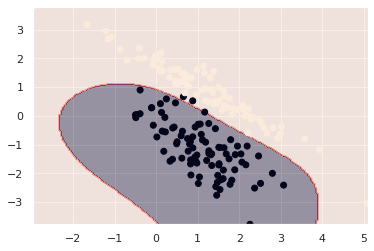

In [ ]:
clf = SVC(C = 1, kernel='rbf')
clf.fit(X, y)

y_pred = clf.predict(X)

print(roc_auc_score(y_pred, y), f1_score(y_pred, y))
plot_decision_boundary(clf, X, y)

the more regularization coefficient the more metric scores. But big regularization coefficient causes overfitting

0.9575892857142858 0.9569892473118279


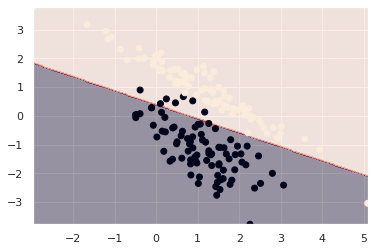

In [ ]:
clf = SVC(C = 0.01, kernel='linear')
clf.fit(X, y)
y_pred = clf.predict(X)

print(roc_auc_score(y_pred, y), f1_score(y_pred, y))
plot_decision_boundary(clf, X, y)

0.978013833992095 0.978021978021978


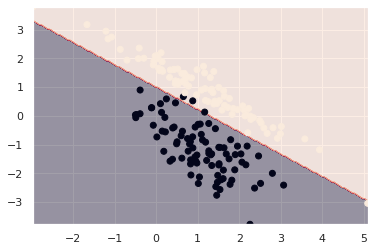

In [ ]:
clf = SVC(C = 0.5, kernel='linear')
clf.fit(X, y)
y_pred = clf.predict(X)

print(roc_auc_score(y_pred, y), f1_score(y_pred, y))
plot_decision_boundary(clf, X, y)

Linear is the most simple kernel, so with not super small C it won't overfit

0.8351573187414499 0.812785388127854


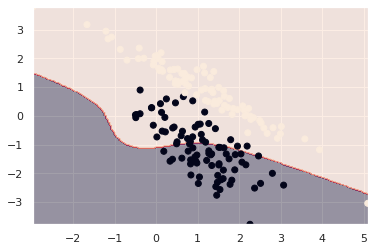

In [ ]:
clf = SVC(C = 0.01, kernel='poly')
clf.fit(X, y)
y_pred = clf.predict(X)

print(roc_auc_score(y_pred, y), f1_score(y_pred, y))
plot_decision_boundary(clf, X, y)

0.9945054945054945 0.9944134078212291


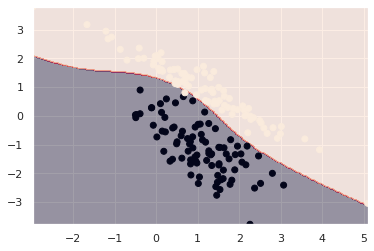

In [ ]:
clf = SVC(C = 1, kernel='poly')
clf.fit(X, y)
y_pred = clf.predict(X)

print(roc_auc_score(y_pred, y), f1_score(y_pred, y))
plot_decision_boundary(clf, X, y)

We can see that polynomial kernel is super sensitive to regularization coefficient. And it is most inclined to overfitting

In this case linear is the best with C = 0.5

# PART 3: Natural Language Processing
#### 7. [2 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: 
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 100
    * fix random state and randomly choose sentences in the folowing proportion "30k : 15k : 7k : 20k: 40k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset 
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and lemmatize the words
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)



In [ ]:
import os
import re

N = 15
full_df = pd.DataFrame()
authors = ['Bryusov', 'Gogol', 'Gorky', 'Tolstoy', 'Pushkin', 'Herzen']

for author in authors:
    path = 'prose/' + author
    files = [file for file in os.listdir(path) if '.txt' in file]

    for file in files:
        f = open(os.path.join(path, file), 'r')
        text = f.read().lower().replace('\n','.')
        text = re.sub(' +', ' ', text)
        text = re.sub('\.+', '.', text)

        sentences = text.split('.')
        sentences = [sent.strip() for sent in sentences if len(sent.strip()) > N]

        df = pd.DataFrame()
        df['sentence'] = sentences
        df['author'] = [author] * len(sentences) 

        full_df = pd.concat([full_df, df])

full_df.head(10)

,sentence,author
0,"теперь, - когда я проснулся",Bryusov
1,записки психопата,Bryusov
2,"конечно, меня с детства считали извращенным",Bryusov
3,"конечно, меня уверяли, что",Bryusov
4,моих чувств не разделяет никто,Bryusov
5,и я привык лгать перед людьми,Bryusov
6,"говорить избитые речи о сострадании и о любви,...",Bryusov
7,"тайне души я был убежден, и убежден даже и теп...",Bryusov
8,человек преступен,Bryusov
9,"мне кажется, что среди всех ощущений, которые ...",Bryusov


In [ ]:
full_df['author'].value_counts()

Tolstoy    90275
Gorky      49312
Bryusov    28491
Gogol      19944
Herzen     17924
Pushkin     9964
Name: author, dtype: int64

In [ ]:
props = [30000, 15000, 7000, 20000, 40000, 3000]

prop_df = pd.DataFrame()
np.random.seed(133)

for i, author in enumerate(full_df['author'].unique()):
    author_df = full_df[full_df['author'] == author].sample(n = props[i], replace=True)
    prop_df = pd.concat([prop_df, author_df])

prop_df = prop_df.reset_index(drop=True)

In [ ]:
prop_df['author'].value_counts()

Pushkin    40000
Bryusov    30000
Tolstoy    20000
Gogol      15000
Gorky       7000
Herzen      3000
Name: author, dtype: int64

In [ ]:
prop_df.sample(5)

,sentence,author
94359,француз-камердинер подал ему башмаки с красным...,Pushkin
72529,преследовать его было невозможно: у михельсона...,Pushkin
13429,"ненавидел жену за ее мелочность, за ее мещанст...",Bryusov
54448,"соня, наташа спали, не раздеваясь, в диванной",Tolstoy
60220,"он говорил, что масонство есть учение христиан...",Tolstoy


In [ ]:
!pip install pymorphy2

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from pymystem3 import Mystem
from nltk.stem.snowball import SnowballStemmer 
import pymorphy2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
morph = pymorphy2.MorphAnalyzer()

stop = set(stopwords.words('russian'))
table = str.maketrans('', '', string.punctuation)

def preprocess_text(text):
    text = ''.join([i for i in text if not i.isdigit()]).strip()
    tokens = text.split(' ')
    tokens = [morph.parse(w.translate(table))[0].normal_form for w in tokens]
    tokens = [w for w in tokens if w not in stop]
    
    text = ' '.join(tokens).strip()
    return text

preprocess_text("бочки, картошка фри и собака 101")

'бочка картошка фри собака'

In [ ]:
if True:
    sentences = prop_df['sentence']
    prep_sentences = sentences.apply(preprocess_text)
    prop_df['sentence'] = prep_sentences

    prop_df.to_csv('prop_df.csv')
else:
    prop_df = pd.read_csv('prop_df.csv', index_col=0).dropna().reset_index(drop=True)
    
prop_df.head()

,sentence,author
0,ответить нестерпимый разговаривать оскорбитель...,Bryusov
1,это отсрочить событие,Bryusov
2,больший зал провести заставить пройти нескольк...,Bryusov
3,оба негр стать жадно наполнять принести,Bryusov
4,мадиэль появляться товарищ ангел огненный одет...,Bryusov


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

vectorizer = CountVectorizer(max_features=5000)
X_count = vectorizer.fit_transform(prop_df['sentence'])

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(prop_df['sentence'])

X = hstack([X_count, X_tfidf]).tocsr()

X

<115000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 1637396 stored elements in Compressed Sparse Row format>

number of frequency with respect to index of vocabulary where as tf-idf consider overall documents of weight of words

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

##### 1. 
* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 3/4 split rate (don't forget to fix the random state)
* train the models using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models

##### 2. 
* using GridSearchCV - find the best parameters for the models (by ROC_AUC score)
* make several plots to address the dependence between ROC_AUC score and parameters
* make conclusions about the models

In [ ]:
classes = authors[:2]
idx = prop_df[prop_df['author'].isin(classes)].index

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(prop_df.iloc[idx]['author'])

X_bin = X[idx]

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_bin, y, test_size=0.25, random_state=42)

svc = SVC(C = 0.5, kernel='linear')
cv_results = cross_validate(svc, X_train, y_train, cv=3, scoring=['f1', 'roc_auc', 'precision', 'recall'])

cv_results

{'fit_time': array([74.46920609, 72.52996182, 72.56299019]),
 'score_time': array([19.19812918, 19.61095381, 19.015517  ]),
 'test_f1': array([0.79496561, 0.80496607, 0.80185669]),
 'test_precision': array([0.88010369, 0.87672956, 0.87829679]),
 'test_recall': array([0.72484654, 0.74406192, 0.73765679]),
 'test_roc_auc': array([0.93734978, 0.9359984 , 0.93707933])}

F1 Score:  0.8269424098807985
ROC AUC Score:  0.8612548945406475
Precision:  0.8985642946317104
Recall:  0.7658951848895983


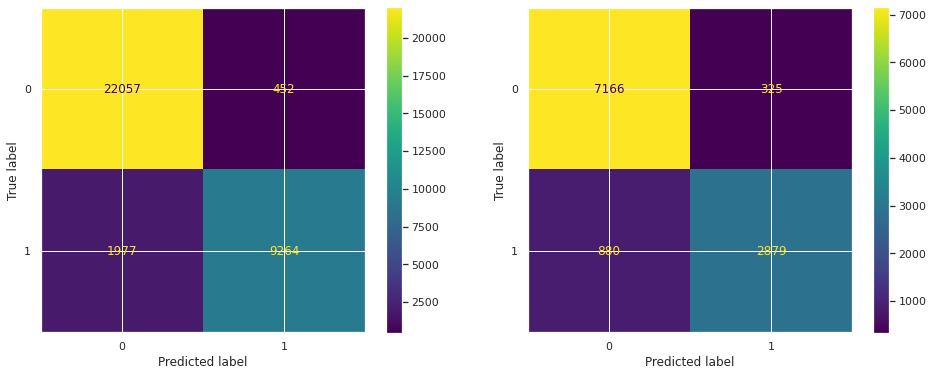

In [ ]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

plot_confusion_matrix(svc, X_train, y_train, ax=axs[0], values_format='d');
plot_confusion_matrix(svc, X_test, y_test, ax=axs[1], values_format='d');

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_bin, y, test_size=0.25, random_state=42)

lr = LogisticRegression(random_state=10, max_iter=1000)
cv_results = cross_validate(lr, X_train, y_train, cv=3, scoring=['f1', 'roc_auc', 'precision', 'recall'])

cv_results

{'fit_time': array([0.72862339, 0.67006302, 0.68862271]),
 'score_time': array([0.03023171, 0.03069329, 0.03057456]),
 'test_f1': array([0.80532397, 0.8083815 , 0.8154494 ]),
 'test_precision': array([0.89093851, 0.88150016, 0.89426752]),
 'test_recall': array([0.73472111, 0.74646384, 0.74939952]),
 'test_roc_auc': array([0.94574091, 0.94420056, 0.94549863])}

F1 Score:  0.8314510364546104
ROC AUC Score:  0.955557451952008
Precision:  0.8986402966625463
Recall:  0.773610002660282


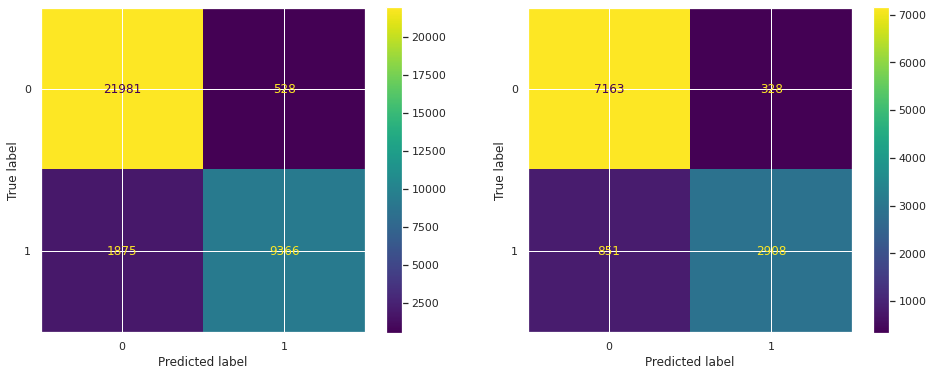

In [ ]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix

lr.fit(X_train, y_train)
y_pred_proba = lr.predict_proba(X_test)[:, 1]
y_pred = lr.predict(X_test)

print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred_proba))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

plot_confusion_matrix(lr, X_train, y_train, ax=axs[0], values_format='d');
plot_confusion_matrix(lr, X_test, y_test, ax=axs[1], values_format='d');

Both have close scores, but logistic regression is much much faster. In SVC roc_auc lower because we predicted not proba's

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':[0.01, 1, 10]}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring='roc_auc')
clf.fit(X_train, y_train)

clf.results

AttributeError: ignored

In [ ]:
cs = [0.01, 0.05, 0.1, 0.25, 0.5, 1, 3, 5, 10]
parameters = {'C':cs}
lr = LogisticRegression(random_state=10, max_iter=1000)
clf = GridSearchCV(lr, parameters, scoring='roc_auc')
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=10, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.05, 0.1, 0.25, 0.5, 1, 3, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [ ]:
clf.best_params_

{'C': 5}

Text(0.5, 1.0, 'C parameter')

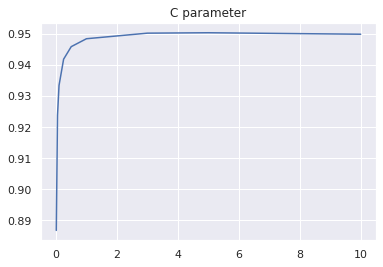

In [ ]:
plt.plot(cs, clf.cv_results_['mean_test_score']);
plt.title('C parameter')

We found that for Logistic Regression best param is 3. Before it score rises after slightly decrease

#### 9. [1 point] Analysing ROC_AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate 

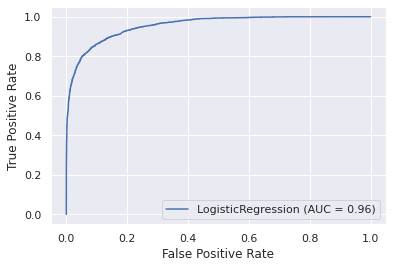

In [ ]:
from sklearn.metrics import plot_roc_curve

svc = svc = SVC(C = 0.5, kernel='linear')
lr.fit(X_train, y_train)
plot_roc_curve(lr, X_test, y_test);

In [ ]:
threshhold = 1
y_pred_proba = lr.predict_proba(X_test)[:, 1]

while True:
    y_pred = (y_pred_proba > threshhold).astype(int)
    (TP, FP, TN, FN) = perf_measure(y_test, y_pred)

    if (FP / (FP + TN)) > 0.3:
        threshhold += 0.01
        y_pred = (y_pred_proba > threshhold).astype(int)
        (TP, FP, TN, FN) = perf_measure(y_test, y_pred)

        print('Threshhold: ', threshhold)
        print('False Positive Rate: ', (FP / (FP + TN)))
        print('True Positive Rate: ', (TP / (TP + FN)))
        break

    threshhold -= 0.01

NameError: ignored

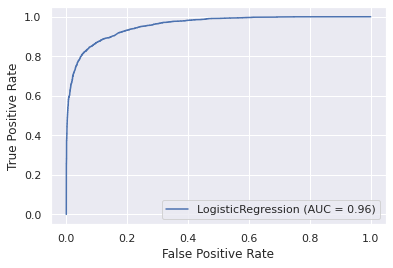

In [ ]:
from sklearn.metrics import plot_roc_curve

lr = LogisticRegression(random_state=10, max_iter=1000, C=3)
lr.fit(X_train, y_train)
plot_roc_curve(lr, X_test, y_test);

In [ ]:
threshhold = 1
y_pred_proba = lr.predict_proba(X_test)[:, 1]

while True:
    y_pred = (y_pred_proba > threshhold).astype(int)
    (TP, FP, TN, FN) = perf_measure(y_test, y_pred)

    if (FP / (FP + TN)) > 0.3:
        threshhold += 0.01
        y_pred = (y_pred_proba > threshhold).astype(int)
        (TP, FP, TN, FN) = perf_measure(y_test, y_pred)

        print('Threshhold: ', threshhold)
        print('False Positive Rate: ', (FP / (FP + TN)))
        print('True Positive Rate: ', (TP / (TP + FN)))
        break

    threshhold -= 0.01

NameError: ignored

### Multiclass logit

#### 10. [1 point] Take the One-VS-Rest classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html">OneVsRestClassifier</a>

* use the whole dataset with 6 authors
* divide the data into train and test samples with 3/4 split rate
* train the model using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)
* using GridSearchCV - find the best parameters for the models (by averaged ROC_AUC score)
* make conclusions about the model

In [ ]:
le = LabelEncoder()
y = le.fit_transform(prop_df['author'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

lr = LogisticRegression(random_state=10, max_iter=1000, C=3)

clf = OneVsRestClassifier(lr)
cv_results = cross_validate(clf, X_train, y_train, cv=3, scoring=['accuracy', 'roc_auc_ovo', 'roc_auc_ovr' ])

cv_results

{'fit_time': array([17.15120125, 16.79922152, 17.40539527]),
 'score_time': array([0.18459749, 0.18560147, 0.18117094]),
 'test_accuracy': array([0.72438261, 0.72132174, 0.72876522]),
 'test_roc_auc_ovo': array([0.87041692, 0.87068683, 0.87439332]),
 'test_roc_auc_ovr': array([0.892775  , 0.89228779, 0.89606915])}

ROC AUC OVO Score:  0.9065410676714503
ROC AUC OVR Score:  0.9329223940323279


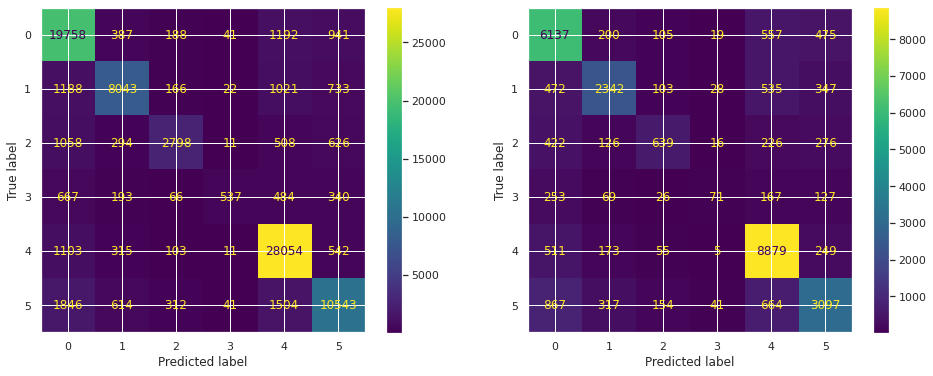

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)

print("ROC AUC OVO Score: ", roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovo'))
print("ROC AUC OVR Score: ", roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovr'))

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

plot_confusion_matrix(clf, X_train, y_train, ax=axs[0], values_format='d');
plot_confusion_matrix(clf, X_test, y_test, ax=axs[1], values_format='d');

In [ ]:
cs = [0.01, 0.05, 0.1, 0.25, 0.5, 1, 3, 5, 10]
parameters = {'estimator__C':cs}
lr = LogisticRegression(random_state=10, max_iter=1000, C=3)
onevsall = OneVsRestClassifier(lr)

clf = GridSearchCV(onevsall, parameters, scoring='roc_auc_ovo')
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=OneVsRestClassifier(estimator=LogisticRegression(C=3,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=1000,
                                                                        multi_class='auto',
                                                                        n_jobs=None,
                                                                        penalty='l2',
                                                                        random_state=10

In [ ]:
clf.best_params_

{'estimator__C': 3}

Text(0.5, 1.0, 'C parameter')

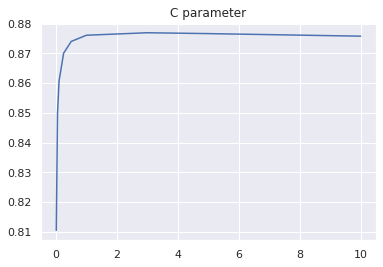

In [ ]:
plt.plot(cs, clf.cv_results_['mean_test_score']);
plt.title('C parameter')